In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import sympy as sy
from sympy.stats import Normal, cdf
import scipy.stats as si
from sympy import init_printing
init_printing()

The first part will simply be comparing the explicit method with the exact Black Scholes solutions.

In [3]:
''' Function for computing Call option price via Black Scholes exact method'''
def euro_call(S, K, T, r, sig):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sig: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    d2 = d1 - (sig*math.sqrt(T))
    
    call = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call
   

Function for exact black-scholes for a European Call.

In [243]:
def blackScholes_OptionPrice_Matrix(Smax, K, T, sigma, r, Ns, Nt):

    dt = T/Nt
    ds = Smax/Ns    ### Price step

    ## Create Matrix of Zeros to store values
    B = np.zeros((Nt+1, Ns+1))

    ### Boundary for time = 0 (Expiry)
    for n in range(0, Ns+1):
        B[0, n] = max((n*ds)-K, 0)

    ### Boundary for Max stock price
    for j in range(1, Nt+1):
        B[j, Ns] = Smax - (K*math.exp(-(j*dt)*r))

    ### Calculate option price for entire grid using Black Scholes exact method
    for j in range(1, Nt+1):
        for n in range(1, Ns+1):
            B[j, n] = euro_call(n*ds, K, j*dt, r, sigma)

    return B

Functions for boundary conditions

In [40]:
# time = T  ### expiry
def call_value_expiry(n, ds):
    price = max((n*ds)-K, 0)
    return price

# Value at stock price = 0
### Not necessary as matrix values will initially be set to zero
def call_value_zero():
    price =  0
    return price

# Value at price Smax
def call_value_Smax(Smax, K, j, dt, r):
    price = Smax - (K*math.exp(-(j*dt)*r))
    return price

Functions for FDM.

In [183]:
### Functions for coefficeints within finite difference scheme

# First coefficient is simply -r
def coeff_1(IR):
    coeff = -IR
    return coeff

# Second coefficient 
def coeff_2(dt):
    coeff = 1/dt
    return coeff

# Third coefficient
def coeff_3(sigma, n):
    coeff = ((sigma**2)*(n**2))/4
    return coeff

# Fourth coefficent
def coeff_4(IR, n):
    coeff = IR*n/4
    return coeff


In [173]:
## Create Marix which will be used as the mesh of option prices/ surface

def matrix_mesh(space_steps, time_steps, delta_s, delta_t):
    ## Create Matrix of Zeros to store values
    V = np.zeros((time_steps+1, space_steps+1))

    ### Boundary for time = 0 (Expiry)
    for n in range(0, space_steps+1):
        V[0, n] = call_value_expiry(n, delta_s)

    ### Boundary for Max stock price
    for j in range(1, time_steps+1):
        V[j, space_steps] = call_value_Smax(Smax, K, j, delta_t, r)

    return V

In [174]:
### Initialising matrix for system of equations Ax = b

### create Matrix A
'''Puts the values from the finite difference scheme into a square matrix which will be used to solve the system of equations.
Returns a (n-2)x(n-2) matrix. where n is the number of points along the price axis'''

def create_A(size, dt):

    # Create matrix
    mat_size = (size-2, size-2)
    Mat = np.zeros((mat_size))

    ## Set top row and bottom row values as these correspond to boundary values for price
    # Row 0
    Mat[0, 0] = -coeff_2(dt) - 2*coeff_3(sigma=sigma, n=1)
    Mat[0, 1] = coeff_3(sigma=sigma, n=2) + coeff_4(r, n=2)

    # Row -1
    Mat[-1, -2] = coeff_3(sigma=sigma, n=size-3) - coeff_4(r, n=size-3)
    Mat[-1, -1] = -coeff_2(dt) - 2*coeff_3(sigma=sigma, n=size-2)

    # Initialise values from rows 1 - (n-1)
    for i in range(size-4):
        Mat[i+1, i] = coeff_3(sigma=sigma, n=i+1) - coeff_4(r, n=i+1)
        Mat[i+1, i+1] = -coeff_2(dt) - 2*coeff_3(sigma=sigma, n=i+2)
        Mat[i+1, i+2] = coeff_3(sigma=sigma, n=i+3) + coeff_4(r, n=i+3)

    return Mat



In [175]:
### Function to initialise vector b from equation Ax = b

'''Creates a (n-2) x 1 vector for the system of equations'''

def create_b(price_mat, dt, time_step):

    # Create vector
    size = price_mat.shape[0] - 2
    #print("size: ", size)
    vector = np.zeros((size, 1))

    ## Set first and last rows as these correspond to boundary values for price
    ## option price terms with n-1 will be zero as n=1. 
    ## Therefore as prices are given by n*ds we have an option price when a stock price is zero
    ## which is eqaul to zero itself.

    # First row
    vector[0] = -price_mat[time_step, 1] * (coeff_1(r) + coeff_2(dt) - 2 * coeff_3(sigma=sigma, n=1)) \
        - price_mat[time_step, 2] * (coeff_3(sigma=sigma, n=2) + coeff_4(IR=r, n=2))

    # Last Row
    vector[-1] = - (price_mat[time_step, -3] * (coeff_3(sigma=sigma, n=size-3) - coeff_4(IR=r, n=size-1))) \
        - (price_mat[time_step, -2] * (coeff_1(r) + coeff_2(dt) - 2 * coeff_3(sigma=sigma, n=size))) \
        - (price_mat[time_step, -1] * (coeff_3(sigma=sigma, n=size+1) + coeff_4(IR=r, n=size+1))) \
        - (price_mat[time_step+1, -1] * (coeff_3(sigma=sigma, n=size+1) + coeff_4(IR=r, n=size+1)))

    #print("1: ", - (price_mat[time_step, -3] * (coeff_3(sigma=sigma, n=size-1) - coeff_4(IR=r, n=size-1))))
    #print("Price [0, -3]: ", price_mat[time_step, -3])
    #print("2: ", - (price_mat[time_step, -2] * (coeff_1 + coeff_2(dt) - 2 * coeff_3(sigma=sigma, n=size))))
    #print("Price [0, -2]: ", price_mat[time_step, -2])
    #print("3: ", - (price_mat[time_step, -1] * (coeff_3(sigma=sigma, n=size+1) + coeff_4(IR=r, n=size+1))))
    #print("Price [0, -1]: ", price_mat[time_step, -1])
    #print("4: ", - (price_mat[time_step+1, -1] * (coeff_3(sigma=sigma, n=size+1) + coeff_4(IR=r, n=size+1))))
    #print("Price [1, -1]: ", price_mat[time_step+1, -1])

    # Rows 1 - 2nd last
    for i in range(size-2):
        vector[i+1] = - (price_mat[time_step, i+1] * (coeff_3(sigma=sigma, n=i+1) - coeff_4(IR=r, n=i+1))) \
        - (price_mat[time_step, i+2] * (coeff_1(r) + coeff_2(dt) - 2 * coeff_3(sigma=sigma, n=i+2))) \
        - (price_mat[time_step, i+3] * (coeff_3(sigma=sigma, n=i+3) + coeff_4(IR=r, n=i+3)))

    return vector 

    


In [215]:
### function to solver system of equations - TDMA (tridiagonal matrix algorithm)
### Thomas algorithm
### algorith from https://www.quantstart.com/articles/Tridiagonal-Matrix-Solver-via-Thomas-Algorithm/

'''This function takes in a matrix (A) and vector (b) and will solve for vector (x) in 
the system of equations Ax=b.
Will return vector x'''

def TDMA(matrix, vector):

    ## create a new matrix which will be bidiagonal and solved iteratively in reverse.
    BD_matrix = np.zeros(matrix.shape)
    ## create new vector which will be the new b vector with the bidiagonal matrix above
    BD_vector = np.zeros(len(vector))

    # set first row - divide row by value in [0, 0]
    b1 = matrix[0, 0]
    BD_matrix[0, 1] = matrix[0, 1]/b1
    BD_vector[0] = vector[0]/b1
    BD_matrix[0, 0] = 1
    
    # Position [-1, -1] will be 1 and the rest of the row will be 0.
    BD_matrix[-1, -1] = 1

    # loop for rows 1 - n

    for i in range(1, len(vector)-1):
        BD_matrix[i, i] = 1
        BD_vector[i] = (vector[i] - BD_vector[i-1] * matrix[i, i-1]) / (matrix[i, i] - BD_matrix[i-1, i] * matrix[i, i-1])
        BD_matrix[i, i+1] = (matrix[i, i+1]) / ((matrix[i, i] - BD_matrix[i-1, i] * matrix[i, i-1]))
        if i == len(vector)-2:
            BD_vector[i+1] = (vector[i+1] - BD_vector[i] * matrix[i+1, i]) / (matrix[i+1, i+1] - BD_matrix[i, i+1] * matrix[i+1, i])

    ## algorithm to solve system in reverse
    
    for i in range(len(vector)-2, -1, -1):
        BD_vector[i] =  BD_vector[i] - (BD_matrix[i, i+1]*BD_vector[i+1])

    return BD_vector
        


In [244]:
# Create matrix which will store option prices
#price_matrix = matrix_mesh(Ns, Nt, ds, dt)
#print(price_matrix)

In [245]:
## Test create matrix function
# Square grid will be used

#vector = create_b(price_matrix, dt=dt, time_step=0)
#print(len(vector))

In [246]:
#bi_vector = TDMA(matrix, vector)
#np.set_printoptions(suppress=True)
#print(np.round(bi_vector, 5))

Implementation of finite difference algorithm - Crank-Nicolson method

In [262]:
### Initial values 

Smax = 10       ### Max stock price (right boundary Value)
T = 1          ### Time until expiry in years
sigma = 0.1     ### Volatility of uderlying stock
r = 0.05        ### Risk-Free rate
K = 4          ### Strike Price

Ns = 1000          ### Number of space steps
Nt = 1000          ### Number of time steps

dt = T/Nt    ### Time step
ds = Smax/Ns ### Price step


In [263]:
#### finite difference algorithm

# Create matrix which will store option prices
price_matrix = matrix_mesh(Ns, Nt, ds, dt)    ## This matrix corresponds to the grid for the FDM

### Loops for Finite Difference method
for j in range(Nt):
    A = create_A(price_matrix.shape[0], dt)
    b = create_b(price_matrix, dt, j)
    solved_prices = TDMA(A, b)
    price_matrix[j+1, 1:-1] = solved_prices
    







In [259]:
#print(price_matrix)

Function for exact Black Scholes.

In [264]:
B = blackScholes_OptionPrice_Matrix(Smax, K, T, sigma, r, Ns, Nt)

In [265]:
Error_Mat = ((price_matrix-B)**2)**(0.5)

print("Maximum Error: ", np.amax(Error_Mat))
print("Average Error: ", np.mean(Error_Mat))

Maximum Error:  0.4245578324792323
Average Error:  0.0862671320432307


In [44]:
J = np.shape(V)[0]
N = np.shape(V)[1]
print(J)
print(N)

11
11


In [47]:
x_d = np.arange(0, N, 1)  ## Need to take shapes from matrix V
y_d = np.arange(0, 1, 1/(J))
x,y = np.meshgrid(x_d, y_d)
print(J)
print(N)

11
11


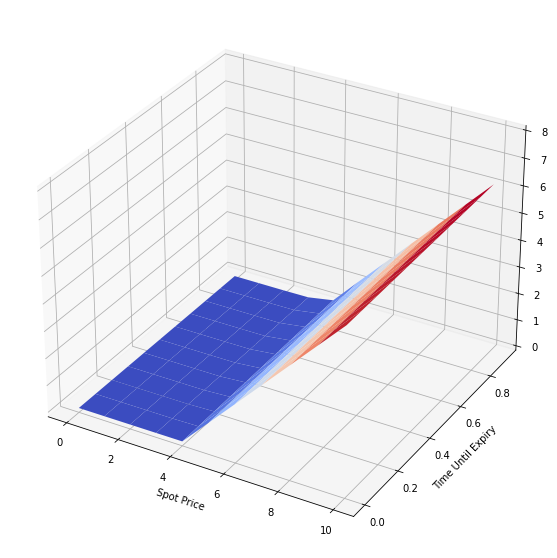

In [48]:
plt.figure(figsize=(10,10))
ax = plt.subplot(111, projection='3d')
plt.xlabel("Spot Price")
plt.ylabel("Time Until Expiry")
ax.set_zlim(0, 8)
ax.plot_surface(x,y,V, cmap=cm.coolwarm)
plt.show()

In [49]:
Error_Mat = ((V-B)**2)**(0.5)
#print(Error_Mat)

In [50]:
print("Maximum Error: ", np.amax(Error_Mat))
print("Average Error: ", np.mean(Error_Mat))

Maximum Error:  0.09321966490393493
Average Error:  0.006625922939801236


FDM using 100x100 mesh.

In [51]:
V100 = finiteDifference_Option_Price(Smax, K, T, sigma, r, Ns=100, Nt = 100)

In [52]:
B100 = blackScholes_OptionPrice_Matrix(Smax, K, T, sigma, r, Ns=100, Nt=100)

In [53]:
Error_Mat = ((V100-B100)**2)**(0.5)
#print(Error_Mat)

In [54]:
print(V100)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.80000000e+00
  5.90000000e+00 6.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.80200000e+00
  5.90200000e+00 6.00199950e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.80399900e+00
  5.90399874e+00 6.00399800e+00]
 ...
 [0.00000000e+00 1.77916011e-45 3.55041537e-42 ... 5.99128605e+00
  6.09128096e+00 6.19127548e+00]
 [0.00000000e+00 2.84321723e-45 5.57328956e-42 ... 5.99318998e+00
  6.09318487e+00 6.19317937e+00]
 [0.00000000e+00 4.51349816e-45 8.69308962e-42 ... 5.99509295e+00
  6.09508782e+00 6.19508230e+00]]


In [55]:
print(B100)

[[0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 5.80000000e+000
  5.90000000e+000 6.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 5.80199950e+000
  5.90199950e+000 6.00199950e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 5.80399800e+000
  5.90399800e+000 6.00399800e+000]
 ...
 [0.00000000e+000 4.90735608e-299 1.53450931e-197 ... 5.99127548e+000
  6.09127548e+000 6.19127548e+000]
 [0.00000000e+000 5.52812109e-296 1.58739201e-195 ... 5.99317937e+000
  6.09317937e+000 6.19317937e+000]
 [0.00000000e+000 5.41162615e-293 1.49678658e-193 ... 5.99508230e+000
  6.09508230e+000 6.19508230e+000]]


In [56]:
print("Maximum Error: ", np.amax(Error_Mat))
print("Average Error: ", np.mean(Error_Mat))

Maximum Error:  0.007973324083766123
Average Error:  0.00010189112774407738


Code below did not work properly and did not feature in the final report.

I will now adjust the alpha values and therefore the ratio of S time steps to T time steps to look at differences in stability and try to find the optimal S/T time step ratio.

I first need a function so I can loop through for different alpha values.

In [436]:
from sympy.stats.crv_types import Dagum
def alpha_test(da, size): 
    
    ### Create array for storage of error values for each alpha value
    alphaError_mat_size = size
    alphaError_Vals = np.zeros(alphaError_mat_size)
    
    ### Loop to cycle through alpha values
    for i in range(1, size+1):
        ### Alpha value
        alpha = i*da
        
        ### Array storing option values using FDM
        V = finiteDifference_Option_Price(Smax, K, T, sigma, r, alpha=alpha)

        ### Array of Black Scholes exact values
        B = blackScholes_OptionPrice_Matrix(Smax, K, T, sigma, r, alpha=alpha)

        ### Error matrix
        Error_Mat = ((V-B)**2)**(0.5)

        #print(np.mean(Error_Mat))
        #print(i)

        ### Storing average error values in array
        alphaError_Vals[i-1] = np.mean(Error_Mat)

    return alphaError_Vals



In [437]:
Error_Values = alpha_test(0.01, 100)

In [438]:
print(Error_Values)

[0.00359138 0.00356028 0.00352408 0.00349559 0.00346251 0.00341049
 0.00338594 0.00334191 0.00332288 0.00329411 0.00325484 0.0032041
 0.0031405  0.00314714 0.00306437 0.00306711 0.00296127 0.00296018
 0.00295904 0.00295812 0.00281427 0.00280927 0.00280421 0.00279923
 0.00279448 0.00259487 0.00258623 0.00257738 0.00256843 0.00255945
 0.00255051 0.00254168 0.002533   0.00223485 0.00222307 0.00221101
 0.00219873 0.00218627 0.00217366 0.00216093 0.00214811 0.00213524
 0.00212233 0.00210942 0.00209651 0.00208364 0.00207082 0.00205806
 0.00204539 0.00203282 0.00152662 0.00151312 0.00149941 0.0014855
 0.00147139 0.00145711 0.00144266 0.00142805 0.0014133  0.00139842
 0.00138341 0.0013683  0.00135308 0.00133777 0.00132237 0.0013069
 0.00129137 0.00127578 0.00126014 0.00124446 0.00122874 0.00121301
 0.00119725 0.00118149 0.00116572 0.00114996 0.00113421 0.00111848
 0.00110277 0.00108709 0.00107145 0.00105585 0.00104031 0.00102482
 0.00100939 0.00099402 0.00097873 0.00096352 0.00094839 0.0009333

In [439]:
### The minimum error 
min_error = np.min(Error_Values)
print("Minimum error value: ", min_error)

Minimum error value:  0.0009333462757784868


In [440]:
### Index of minimum error so we can establish the corresponding alpha
alpha_index = np.where(Error_Values == min_error)
print("Index for optimal alpha value: ", alpha_index[0][0])


Index for optimal alpha value:  89


In [452]:
### Optimal Alpha Value
Optimal_alpha = (alpha_index[0][0]-1)*0.01
print("Optimal Alpha: ", Optimal_alpha)

Optimal Alpha:  0.88


Now we want to try another FDM with a smaller difference using the alpha we have found.

In [458]:
V1 = finiteDifference_Option_Price(Smax, K, T, sigma, r, ds=1, alpha=Optimal_alpha)

In [459]:
print(np.shape(V1))
print(V1)

(2, 11)
[[0.         0.         0.         0.         0.         1.
  2.         3.         4.         5.         6.        ]
 [0.         0.         0.         0.         0.2464     1.176
  2.176      3.176      4.176      5.176      6.17218417]]


In [461]:
B1 = blackScholes_OptionPrice_Matrix(Smax, K, T, sigma, r, ds=1, alpha=Optimal_alpha)

In [462]:
Error_Mat = ((V1-B1)**2)**(0.5)

In [463]:
print("Maximum Error: ", np.amax(Error_Mat))
print("Average Error: ", np.mean(Error_Mat))

Maximum Error:  0.0038158298921864287
Average Error:  0.0009635186288146312
